In [1]:
# General imports
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit import *

from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitMapper
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.primitives import Estimator


# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
molecule = "Li .0 .0 .0; H .0 .0 1.6"
distances=np.arange(0.5,4.25,0.25)

In [3]:
for i,d in enumerate(distances):
    print('step', i)
    #setup my experiment
    driver=PySCFDriver(molecule.format(d/2),basis='sto3g')
    qmolecule = driver.run()
    #print(problem.num_particles)
    hamiltonian = qmolecule.hamiltonian
    coefficients = hamiltonian.electronic_integrals
    print(coefficients.alpha)
    # Generate the second-quantized operators
    hamiltonian = qmolecule.hamiltonian.second_q_op()
    second_q_ops = qmolecule.second_q_ops()

    # Hamiltonian
    main_op = second_q_ops[0]

step 0
Polynomial Tensor
 "+-":
array([[-4.72739313e+00,  1.05499678e-01,  1.66961408e-01,
         5.05470023e-17, -5.82354005e-18, -3.46772043e-02],
       [ 1.05499678e-01, -1.49264622e+00,  3.28928273e-02,
         5.87702127e-17, -8.75172580e-17, -5.27078777e-02],
       [ 1.66961408e-01,  3.28928273e-02, -1.12554474e+00,
        -4.52182231e-17,  4.11013225e-17,  3.04455720e-02],
       [ 5.05470023e-17,  5.87702127e-17, -4.52182231e-17,
        -1.13579985e+00,  7.54176360e-17, -1.07634440e-16],
       [-5.82354005e-18, -8.75172580e-17,  4.11013225e-17,
         7.25573110e-17, -1.13579985e+00, -5.42943211e-18],
       [-3.46772043e-02, -5.27078777e-02,  3.04455720e-02,
        -1.07634440e-16, -5.42943211e-18, -9.50966592e-01]])
 "++--":
array([ 1.65856669e+00, -1.11709978e-01,  1.33375784e-02,  3.66701041e-01,
        6.21030051e-03,  4.87310967e-01, -1.38574628e-01,  1.12157746e-02,
       -1.58680850e-02,  2.16622450e-02,  1.34512761e-02, -3.34939094e-03,
       -4.85795923e

In [4]:
from qiskit_nature.second_q.mappers import ParityMapper, BravyiKitaevMapper, JordanWignerMapper, QubitMapper, InterleavedQubitMapper

# Setup the mapper and qubit converter
mapper_type = 'JordanWignerMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = InterleavedQubitMapper(mapper)

# The fermionic operators are mapped to qubit operators

#qubit_op = converter.two_qubit_reduction(main_op, num_particles)
qubit_op = converter.map(hamiltonian)

In [5]:
from qiskit_nature.second_q.circuit.library import HartreeFock

num_particles = qmolecule.num_particles
num_spin_orbitals = qmolecule.num_spatial_orbitals * 2
init_state = HartreeFock(num_spin_orbitals,num_particles,converter)
print(init_state)

      ┌───┐
 q_0: ┤ X ├
      ├───┤
 q_1: ┤ X ├
      ├───┤
 q_2: ┤ X ├
      ├───┤
 q_3: ┤ X ├
      └───┘
 q_4: ─────
           
 q_5: ─────
           
 q_6: ─────
           
 q_7: ─────
           
 q_8: ─────
           
 q_9: ─────
           
q_10: ─────
           
q_11: ─────
           
q_12: ─────
           
q_13: ─────
           
q_14: ─────
           
q_15: ─────
           
q_16: ─────
           
q_17: ─────
           
q_18: ─────
           
q_19: ─────
           
q_20: ─────
           
q_21: ─────
           
q_22: ─────
           
q_23: ─────
           


## VQE

In [6]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.second_q.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit_algorithms.utils import algorithm_globals

# we will iterate over these different optimizers
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
    algorithm_globals.random_seed = 50

    print(qmolecule.num_particles)
    # print(problem.num_parameters)
    print(qmolecule.num_spatial_orbitals)

    transformer = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2)
    transformed_problem = transformer.transform(qmolecule)
    print(transformed_problem.num_particles)
    print(transformed_problem.num_spatial_orbitals)

    mapper = JordanWignerMapper()
    # Choosing the ansatz
    ansatz_type = "TwoLocal"


# Parameters for q-UCC ansatz
    #num_particles = (problem.molecule_data_transformed.num_alpha,problem.molecule_data_transformed.num_beta)
    #num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals


# Putting arguments for twolocal
    if ansatz_type == "TwoLocal":
        ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
    
    elif ansatz_type == "UCCSD":    
        ansatz = UCCSD(    transformed_problem.num_spatial_orbitals,
    transformed_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        transformed_problem.num_spatial_orbitals,
        transformed_problem.num_particles,
        mapper,
        ),)
    elif ansatz_type == "PUCCD":    
        ansatz = PUCCD(    transformed_problem.num_spatial_orbitals,
    transformed_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        transformed_problem.num_spatial_orbitals,
        transformed_problem.num_particles,
        mapper,
        ),)
    elif ansatz_type == "SUCCD":    
        ansatz = SUCCD(transformed_problem.num_spatial_orbitals,
    transformed_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        transformed_problem.num_spatial_orbitals,
        transformed_problem.num_particles,
        mapper,
        ),)
    
    #ansatz = UCCSD(
    #transformed_problem.num_spatial_orbitals,
    #transformed_problem.num_particles,
    #mapper,
    #initial_state=HartreeFock(
     #   transformed_problem.num_spatial_orbitals,
      #  transformed_problem.num_particles,
       # mapper,
       # ),
    #)

    counts = []
    values = []

    def iteration_value(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

        
    vqe = VQE(Estimator(), ansatz, optimizer, callback=iteration_value)
    vqe_result = vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

    #vqe_solver = VQE(Estimator(), ansatz, optimizers, callback=iteration_value)
    #vqe_solver.initial_point = [0.0] * ansatz.num_parameters
print("\rOptimization complete      ");

Optimizer: COBYLA        (2, 2)
6
(1, 1)
2
Optimizer: L_BFGS_B        (2, 2)
6
(1, 1)
2
Optimizer: SLSQP        (2, 2)
6
(1, 1)
2
Optimization complete      


In [7]:
numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(qubit_op)
ref_value = result.eigenvalue.real

In [8]:
print(f"VQE value: {vqe_result:.5f}")
print(f"Reference value: {ref_value:.5f}")

VQE value: -8.85434
Reference value: -8.87453


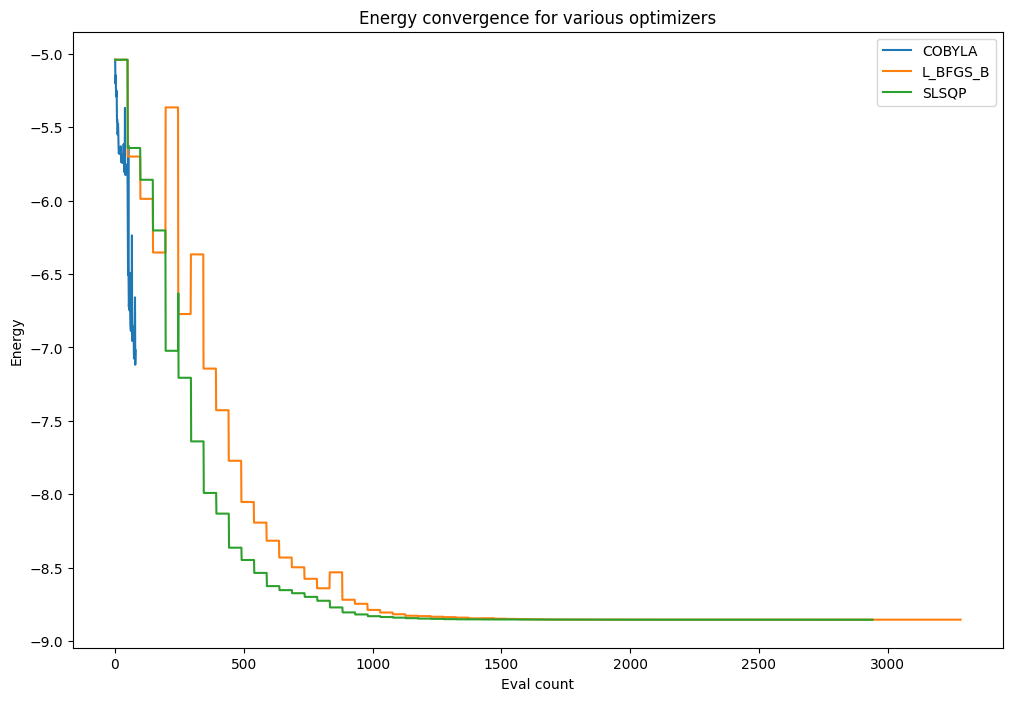

In [9]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_counts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");


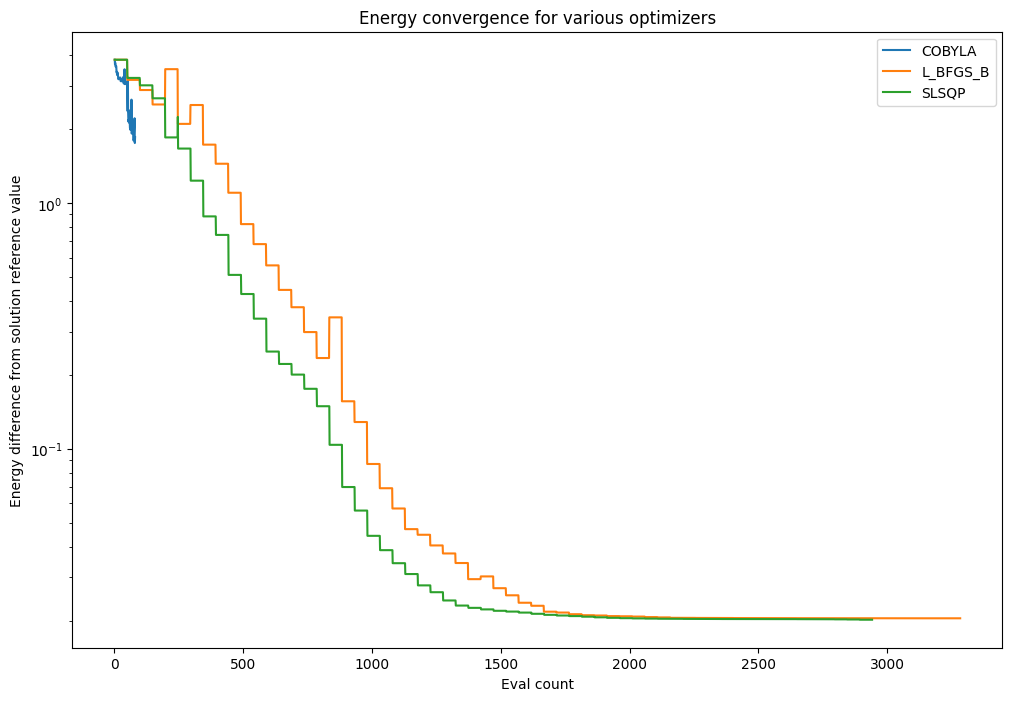

In [10]:
pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(
        converge_counts[i],
        abs(ref_value - converge_vals[i]),
        label=type(optimizer).__name__,
    )
pylab.xlabel("Eval count")
pylab.ylabel("Energy difference from solution reference value")
pylab.title("Energy convergence for various optimizers")
pylab.yscale("log")
pylab.legend(loc="upper right");

In [11]:
import qiskit

qiskit.version.get_version_info()

'1.0.0'